In [3]:
import sys
!{sys.executable} -m pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=0cac82414c4e4a7c3a1b0ece85c109c3fa1d582c1ce442fde1e8a6b8d05bd8d7
  Stored in directory: /Users/aristophanesalbertusalvin/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Load data from .txt files and make the train-test splits.
# Since we're working with text data, we need to vectorize the documents / turn each document
# into a point vector in a n-dimentions space. 
# Moreover, rather than simply using the word counts, we want to use the Term Frequency as feature value.

review_files = load_files('./cleaned_op_spam', encoding='latin-1')
x_train, x_test, y_train, y_test = train_test_split(review_files.data, review_files.target, test_size=0.2)

vectorizer = TfidfVectorizer(stop_words='english')
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# print(x_trainvec.toarray())
# print(vectorizer.get_feature_names_out())

print('===== Target classes =====')
print(review_files.target_names)
# print(review_files)

===== Target classes =====
['negative deceptive', 'negative truthful', 'positive deceptive', 'positive truthful']


In [8]:
# Fit and test the models

mnb = MultinomialNB()
preds_mnb = mnb.fit(x_train_vec, y_train).predict(x_test_vec)
print("MNB correct predictions %d out of %d" % ((y_test == preds_mnb).sum(), x_testvec.shape[0]))

loreg1 = LogisticRegression(solver='lbfgs')
preds_logreg1 = loreg1.fit(x_train_vec, y_train).predict(x_test_vec)
print("LReg-LBFGS correct predictions %d out of %d" % ((y_test == preds_logreg1).sum(), x_testvec.shape[0]))

logreg2 = LogisticRegression(solver='liblinear')
preds_logreg2 = logreg2.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Liblinear correct predictions {(y_test == preds_logreg2).sum()} out of {x_testvec.shape[0]}")

logreg3 = LogisticRegression(solver='saga')
preds_logreg3 = logreg3.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Saga correct predictions {(y_test == preds_logreg3).sum()} out of {x_testvec.shape[0]}")

dectree = DecisionTreeClassifier()
preds_dectree = dectree.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Decision Tree correct predictions {(y_test == preds_dectree).sum()} out of {x_testvec.shape[0]}")

rforest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
preds_rforest = rforest.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Random Forest correct predictions {(y_test == preds_rforest).sum()} out of {len(y_test)}")

MNB correct predictions 248 out of 320
LReg-LBFGS correct predictions 262 out of 320
LReg-Liblinear correct predictions 258 out of 320
LReg-Saga correct predictions 263 out of 320
Decision Tree correct predictions 170 out of 320
Random Forest correct predictions 189 out of 320


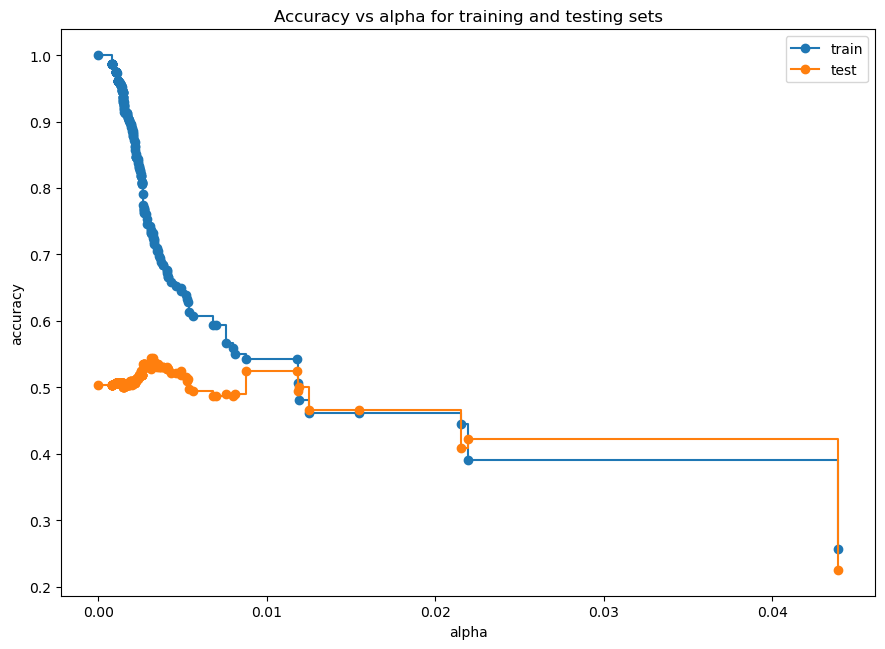

In [14]:
# Attempt to optimize the Decision Tree using Cost-Complexity Pruning technique

path = dectree.cost_complexity_pruning_path(x_train_vec, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas)
# print(impurities)

dtrees = []
for ccp_alpha in ccp_alphas:
    dtr = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(x_train_vec, y_train)
    dtrees.append(dtr)
# print(f"Number of nodes in the last tree is: {dectrees[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

train_scores = [dtr.score(x_train_vec, y_train) for dtr in dtrees]
test_scores = [dtr.score(x_test_vec, y_test) for dtr in dtrees]

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7.5)
fig.set_dpi(100)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# CONCLUSION: Accuracy optimizes at alpha 0.01. However, the score remains at ±52% so there is no noticeable 
# improvement achieved by the cost-complexity pruning, compared to the simple un-pruned tree.

In [9]:
neg_dec_prob_sorted = mnb.feature_log_prob_[0, :].argsort()[::-1]
neg_tru_prob_sorted = mnb.feature_log_prob_[1, :].argsort()[::-1]
pos_dec_prob_sorted = mnb.feature_log_prob_[2, :].argsort()[::-1]
pos_tru_prob_sorted = mnb.feature_log_prob_[3, :].argsort()[::-1]

print(np.take(vectorizer.get_feature_names_out(), neg_dec_prob_sorted[:10]))
print(neg_dec_prob_sorted[:10])
print(np.take(vectorizer.get_feature_names_out(), neg_tru_prob_sorted[:10]))
print(neg_tru_prob_sorted[:10])
print(np.take(vectorizer.get_feature_names_out(), pos_dec_prob_sorted[:10]))
print(pos_dec_prob_sorted[:10])
print(np.take(vectorizer.get_feature_names_out(), pos_tru_prob_sorted[:10]))
print(pos_tru_prob_sorted[:10])

['room' 'hotel' 'chicago' 'stay' 'service' 'like' 'did' 'desk'
 'experience' 'night']
[6295 3741 1463 7086 6559 4372 2246 2209 2833 4989]
['room' 'hotel' 'night' 'stay' 'bed' 'did' 'desk' 'service' 'called'
 'told']
[6295 3741 4989 7086  913 2246 2209 6559 1267 7588]
['hotel' 'chicago' 'stay' 'great' 'room' 'staff' 'rooms' 'service'
 'definitely' 'comfortable']
[3741 1463 7086 3424 6295 7035 6298 6559 2132 1636]
['great' 'hotel' 'room' 'location' 'staff' 'stay' 'chicago' 'stayed'
 'clean' 'comfortable']
[3424 3741 6295 4437 7035 7086 1463 7087 1534 1636]


In [10]:
def run_cross_validation(nfolds, ngram=1):
    tf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(ngram, ngram))
    x_train_vec = tf_vectorizer.fit_transform(review_files.data)
    y_train_vec = review_files.target

    mnbayes = MultinomialNB()
    logreg = LogisticRegression(solver='lbfgs')
    logreg2 = LogisticRegression(solver='liblinear')
    logreg3 = LogisticRegression(solver='saga')
    dtree = DecisionTreeClassifier()
    ranForest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    
    # Naive Bayes
    bayes_acc = cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    bayes_prec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    bayes_rec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    #Logistic regression
    lg_acc = cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    lg_prec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg_rec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg2_acc = cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    lg2_prec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg2_rec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg3_acc = cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    lg3_prec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg3_rec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
            
    dt_acc = cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    dt_prec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    dt_rec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    ranForest_acc = cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    ranForest_prec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    ranForest_rec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    print(f'         Model                         | Accuracy | Precision | Recall')
    print(f'Naive Bayes                            | {round(bayes_acc, 3)}    | {round(bayes_prec, 3)}    | {round(bayes_rec, 3)}')
    print(f'Logistic Regression - LBFGS solver     | {round(lg_acc, 3)}    | {round(lg_prec, 3)}    | {round(lg_rec, 3)}')
    print(f'Logistic Regression - Liblinear solver | {round(lg2_acc, 3)}    | {round(lg2_prec, 3)}    | {round(lg2_rec, 3)}')
    print(f'Logistic Regression - Saga solver      | {round(lg3_acc, 3)}    | {round(lg3_prec, 3)}    | {round(lg3_rec, 3)}')
    print(f'Decision Tree                          | {round(dt_acc, 3)}    | {round(dt_prec, 3)}    | {round(dt_rec, 3)}')
    print(f'Random Forest                          | {round(ranForest_acc, 3)}    | {round(ranForest_prec, 3)}    | {round(ranForest_rec, 3)}')

In [ ]:
print('===== UNIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=1)

print('===== UNIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=1)

print('\n===== BIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=2)

print('\n===== BIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=2)

===== UNIGRAM, 5 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.791    | 0    | 0
Logistic Regression - LBFGS solver     | 0.817    | 0    | 0
Logistic Regression - Liblinear solver | 0.817    | 0    | 0
Logistic Regression - Saga solver      | 0.817    | 0    | 0
Decision Tree                          | 0.513    | 0    | 0
Random Forest                          | 0.593    | 0    | 0
===== UNIGRAM, 10 folds cv =====
